In [32]:
import pandas as pd
import mysql.connector
import pymysql
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [19]:
credentials = pd.read_csv('db_credentials.csv')

In [20]:
# Extract credentials
db_config = {
    'host': credentials.loc[0, 'host'],
    'user': credentials.loc[0, 'user'],
    'password': credentials.loc[0, 'password'],
    'database': credentials.loc[0, 'database'],
    'port': int(credentials.loc[0, 'port'])
}

In [21]:
# Creating a SQLAlchemy engine
engine = create_engine(f"mysql+pymysql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

In [28]:
query = "SELECT * FROM rfm_analysis"
rfm_df = pd.read_sql(query, engine)
rfm_df.head()

,CustomerID,recency,frequency,monetary
0,15,1286,142,1.512726e+06
1,20,1291,167,1.523888e+06
2,16,1285,135,1.547774e+06
3,48,1292,172,1.670109e+06
4,49,1289,152,1.503467e+06


#### Standardizing RFM Values

In [31]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['recency', 'frequency', 'monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled_df.head()

,Recency,Frequency,Monetary
0,-0.580378,-1.264920,-0.710687
1,0.355715,0.509659,-0.654477
2,-0.767596,-1.761801,-0.534196
3,0.542934,0.864575,0.081853
4,-0.018722,-0.555088,-0.757315


#### Determining the Optimal Number of Clusters Using the Elbow Method

In [33]:
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_df)
    sse.append(kmeans.inertia_)

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


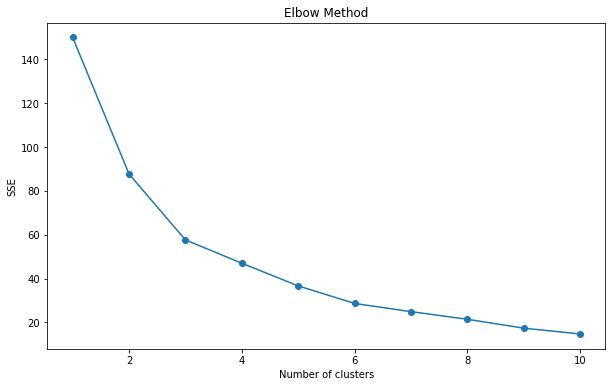

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

#### Clustering using K-means

In [35]:
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)

rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

rfm_df.head()

,CustomerID,recency,frequency,monetary,Cluster
0,15,1286,142,1.512726e+06,0
1,20,1291,167,1.523888e+06,1
2,16,1285,135,1.547774e+06,0
3,48,1292,172,1.670109e+06,1
4,49,1289,152,1.503467e+06,0


#### Analyzing Cluster Characteristics

In [37]:
cluster_analysis = rfm_df.groupby('Cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Customer Count'}).reset_index()

print(cluster_analysis)

   Cluster      recency   frequency      monetary  Customer Count
0        0  1287.400000  149.880000  1.510802e+06              25
1        1  1294.000000  165.000000  1.698425e+06               8
2        2  1308.500000  155.000000  1.519597e+06               2
3        3  1286.733333  174.266667  1.886406e+06              15


#### Writing the clustered data back to the database

In [38]:
rfm_df.to_sql('rfm_clustered', engine, if_exists='replace', index=False)
print("Clustered data has been written back to the database.")

Exception during reset or similar
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\pymysql\connections.py", line 782, in _read_bytes
    data = self._rfile.read(num_bytes)
  File "C:\Users\Dell\anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 988, in _reset
    pool._dialect.do_rollback(self)
  File "C:\Users\Dell\anaconda3\lib\site-packages\sqlalchemy\engine\default.py", line 682, in do_rollback
    dbapi_connection.rollback()
  File "C:\Users\Dell\anaconda3\lib\site-packages\pymysql\connections.py", line 493

Clustered data has been written back to the database.
